<a href="https://colab.research.google.com/github/arkalim/PyTorch/blob/master/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Download the Dataset and unzip the files

In [0]:
!wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/stairs.zip    
!unzip 'stairs.zip' 

--2019-06-25 04:47:23--  http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/stairs.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.122.255.148, 2a02:26f0:7b:895::e59, 2a02:26f0:7b:89d::e59
Connecting to download.microsoft.com (download.microsoft.com)|92.122.255.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1496412431 (1.4G) [application/octet-stream]
Saving to: ‘stairs.zip’

stairs.zip          100%[===================>]   1.39G  43.2MB/s    in 33s     

2019-06-25 04:47:57 (43.4 MB/s) - ‘stairs.zip’ saved [1496412431/1496412431]

Archive:  stairs.zip
   creating: stairs/
  inflating: stairs/seq-01.zip       
  inflating: stairs/seq-02.zip       
  inflating: stairs/seq-03.zip       
  inflating: stairs/seq-04.zip       
  inflating: stairs/seq-05.zip       
  inflating: stairs/seq-06.zip       
  inflating: stairs/stairs.png       
 extracting: stairs/TestSplit.txt    
  inflating: stairs/TrainSplit.txt 

In [0]:
%%capture

os.remove('stairs.zip')
os.chdir('stairs')

!unzip 'seq-01.zip'  
!unzip 'seq-02.zip'  
!unzip 'seq-03.zip'  
!unzip 'seq-04.zip'  
!unzip 'seq-05.zip'  
!unzip 'seq-06.zip'  

os.remove('seq-01.zip')
os.remove('seq-02.zip')
os.remove('seq-03.zip')
os.remove('seq-04.zip')
os.remove('seq-05.zip')
os.remove('seq-06.zip')

os.chdir('/content')

In [0]:
os.listdir('stairs')

['seq-05',
 'TrainSplit.txt',
 'seq-04',
 'seq-02',
 'stairs.png',
 'seq-03',
 'seq-06',
 'seq-01',
 'TestSplit.txt']

## Create dataset from filenames

In [0]:
class dataset_from_filenames(Dataset):
    
    def __init__(self,root_dir, folder_names, transforms):
        
        self.image_filenames = []
        self.label_filenames = []
        self.transforms = transforms
        
        for folder in os.listdir(root_dir):
            if folder in folder_names:
                for filename in os.listdir(os.path.join(root_dir , folder)):
                    if filename.endswith('color.png'):
                        self.image_filenames.append(os.path.join(os.path.join(root_dir , folder), filename))
                    elif filename.endswith('pose.txt'):
                        self.label_filenames.append(os.path.join(os.path.join(root_dir , folder), filename))   
                        
        self.image_filenames.sort()  
        self.label_filenames.sort()
        
        # Function to generate consecutive pairs of images
        def pair(arr):
            paired = []
            for i in range(len(arr)-1):
                paired.append([arr[i], arr[i + 1]])
            return paired
        
        self.image_filenames = pair(self.image_filenames)
        self.label_filenames = pair(self.label_filenames)
    
    # You must override __getitem__ and __len__
    def __len__(self):
        return len(self.image_filenames)
    
    # function to convert rotation matrix into quarternion
    def quaternion_from_matrix(sekf, matrix, isprecise=False):
        """Return quaternion from rotation or transformation matrix."""

        M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
        if isprecise:
            q = np.empty((4, ))
            t = np.trace(M)
            if t > M[3, 3]:
                q[0] = t
                q[3] = M[1, 0] - M[0, 1]
                q[2] = M[0, 2] - M[2, 0]
                q[1] = M[2, 1] - M[1, 2]
            else:
                i, j, k = 0, 1, 2
                if M[1, 1] > M[0, 0]:
                    i, j, k = 1, 2, 0
                if M[2, 2] > M[i, i]:
                    i, j, k = 2, 0, 1
                t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
                q[i] = t
                q[j] = M[i, j] + M[j, i]
                q[k] = M[k, i] + M[i, k]
                q[3] = M[k, j] - M[j, k]
                q = q[[3, 0, 1, 2]]
            q *= 0.5 / math.sqrt(t * M[3, 3])
        else:
            m00 = M[0, 0]
            m01 = M[0, 1]
            m02 = M[0, 2]
            m10 = M[1, 0]
            m11 = M[1, 1]
            m12 = M[1, 2]
            m20 = M[2, 0]
            m21 = M[2, 1]
            m22 = M[2, 2]
            # symmetric matrix K
            K = np.array([[m00-m11-m22, 0.0,         0.0,         0.0],
                             [m01+m10,     m11-m00-m22, 0.0,         0.0],
                             [m02+m20,     m12+m21,     m22-m00-m11, 0.0],
                             [m21-m12,     m02-m20,     m10-m01,     m00+m11+m22]])
            K /= 3.0
            # quaternion is eigenvector of K that corresponds to largest eigenvalue
            w, V = np.linalg.eigh(K)
            q = V[[3, 0, 1, 2], np.argmax(w)]
        if q[0] < 0.0:
            np.negative(q, q)
        return q
    
    def label_to_transformation(self,filenames):
    
        translations = []
        quarternions = []

        for filename in filenames:

            transformation_matrix = []

            # Reading Text files line by line to parse them
            file = open(filename,'r')
            lines = file.readlines()

            for line_num in range(len(lines)):
                line = lines[line_num]
                r1 , r2 , r3 , t , _= line.split('\t')
                transformation_matrix.append([r1 , r2 , r3 , t])

            # specifying data type as the values are string by default    
            transformation_matrix = np.array(transformation_matrix, dtype = np.float32)

            translation = transformation_matrix[:3,3]
            quarternion = self.quaternion_from_matrix(transformation_matrix)

            translations.append(torch.tensor(translation))
            quarternions.append(torch.tensor(quarternion))

        return translations , quarternions
    
    def __getitem__(self,index):
        
        image1 = Image.open(self.image_filenames[index][0]) 
        image2 = Image.open(self.image_filenames[index][1])
        image1 = self.transforms(image1)
        image2 = self.transforms(image2) 
        
        translation, rotation = self.label_to_transformation(self.label_filenames[index])
        
        return image1, image2, translation[0], translation[1], rotation[0].to(torch.float32), rotation[1].to(torch.float32)

## Create Train and Valid Dataset

In [0]:
# random crops for train
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

# centre crop for valid
valid_transforms = transforms.Compose([
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

train_dataset = dataset_from_filenames('stairs', ['seq-01','seq-02','seq-03','seq-04','seq-05'], train_transforms)
valid_dataset = dataset_from_filenames('stairs', ['seq-06'], valid_transforms)

print(len(train_dataset))
print(len(valid_dataset))

# generate batches and no shuffle
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,shuffle=False)

2499
499


### Visualise Train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Translation: tensor([-1.4903, -0.4964, -0.0548])
Rotation: tensor([ 0.9666, -0.1869,  0.1344,  0.1128])


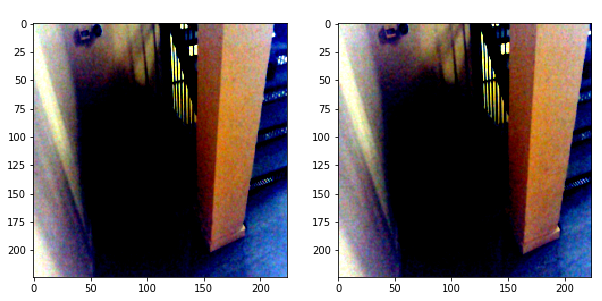

In [0]:
image1, image2, translation1, translation2, rotation1, rotation2 = train_dataset[0]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image1.numpy().transpose(1,2,0))
plt.title('Prev Frame', color='w')

plt.subplot(1,2,2)
plt.imshow(image2.numpy().transpose(1,2,0))
plt.title('Current Frame', color='w')

print('Translation: {}'.format(translation2))
print('Rotation: {}'.format(rotation2))

## Print the layer names in the original Resnet Model

In [0]:
feature_extractor = models.resnet50(pretrained=True)

for index, (name, layer) in enumerate(feature_extractor.named_children()):
    print('Index: {}  {}'.format(index, name))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 29696111.50it/s]


Index: 0  conv1
Index: 1  bn1
Index: 2  relu
Index: 3  maxpool
Index: 4  layer1
Index: 5  layer2
Index: 6  layer3
Index: 7  layer4
Index: 8  avgpool
Index: 9  fc


## Odometry and Pose Streams

In [0]:
import torch.nn as nn
from torch.hub import load_state_dict_from_url

__all__ = ['ResNet', 'resnet50']

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

def conv3x3(in_planes, out_planes, stride=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,base_width=64, dilation=1):
        super(Bottleneck, self).__init__()
        
        width = int(planes * (base_width / 64.))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride, dilation)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet_Odom(nn.Module):

    def __init__(self, block, layer, num_classes=1000, width_per_group=64):
        super(ResNet_Odom, self).__init__()

        self.inplanes = 2048
        self.dilation = 1
    
        self.base_width = width_per_group
        
        self.layer4 = self._make_layer(Bottleneck, 512, layer, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        previous_dilation = self.dilation
       
        if stride != 1 or self.inplanes != planes * 4:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * 4, stride),
                nn.BatchNorm2d(planes * 4),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                base_width=self.base_width, dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):   
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        return x
    
class ResNet_Pose(nn.Module):

    def __init__(self, block, layer=[6,3], num_classes=1000, width_per_group=64):
        super(ResNet_Pose, self).__init__()

        self.inplanes = 512
        self.dilation = 1
        self.base_width = width_per_group
        
        self.linear_layer = nn.Linear(7, 14*14*1024)
        
        self.layer3 = self._make_layer(Bottleneck, 256, layer[0], stride=2)
        
        self.inplanes = 2048
        
        self.last_layer = self._make_layer(Bottleneck, 1024, layer[1], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        previous_dilation = self.dilation
       
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                base_width=self.base_width, dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x, prev_pose):
        x = self.layer3(x)
        
        feed = self.linear_layer(prev_pose)
        feed = feed.view(-1,1024,14,14)
        x = torch.cat([x, feed], dim=1)
        
        x = self.last_layer(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        return x    


def resnet_odom(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet_Odom(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict, strict = False)
    return model

def resnet_pose(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet_Pose(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict, strict = False)
    return model

class OdomNet(nn.Module):
    def __init__(self, pretrained=False, progress=True, **kwargs):
        super(OdomNet, self).__init__()
        
        self.resnet_4=resnet_odom('resnet50', Bottleneck,3, pretrained, progress, **kwargs)
        self.fc1 = nn.Linear(2048,1024)
        self.fc2 = nn.Linear(1024,3)
        self.fc3 = nn.Linear(1024,4)
        
    def forward(self,x):   
        x = self.resnet_4(x)
        x = self.fc1(x)
        position = self.fc2(x)
        orientation = self.fc3(x)
        return position, orientation
    
class PoseNet(nn.Module):
    def __init__(self, pretrained=False, progress=True, **kwargs):
        super(PoseNet, self).__init__()
        
        self.resnet_3_4=resnet_pose('resnet50', Bottleneck,[6,3], pretrained, progress, **kwargs)
        self.fc1 = nn.Linear(4096,1024)
        self.fc2 = nn.Linear(1024,3)
        self.fc3 = nn.Linear(1024,4)
        
    def forward(self,x, feed):   
        x = self.resnet_3_4(x, feed)
        x = self.fc1(x)
        position = self.fc2(x)
        orientation = self.fc3(x)
        return position, orientation    

## Define the current stream

In [0]:
class Current_Stream(nn.Module):
    
    def __init__(self):
        super(Current_Stream, self).__init__()
        
        self.feature_extractor = models.resnet50(pretrained=True)
        self.block_3 = nn.Sequential(*list(self.feature_extractor.children())[:6]) 
        self.block_5 = nn.Sequential(*list(self.feature_extractor.children())[6:7]) 
        
    def forward(self, x):
        block_3_out = self.block_3(x)
        x = self.block_5(block_3_out)
        return x, block_3_out        

In [0]:
class VLocNet(nn.Module):
    
    def __init__(self):
        super(VLocNet, self).__init__()
        
        self.feature_extractor = models.resnet50(pretrained=True)
        self.features_2 = Current_Stream()  
        self.features_1 = nn.Sequential(*list(self.feature_extractor.children())[:7])
        self.odom_stream = OdomNet(pretrained=False)
        self.pose_stream = PoseNet(pretrained=True)
        
    def forward(self, x1, x2, pos_prev, orien_prev):
        x2, block_3_out = self.features_2(x2)
        x1 = self.features_1(x1)
        x = torch.cat([x1,x2], dim=1)
        
        pose_prev = torch.cat([pos_prev, orien_prev], dim=1)
        
        position_pose, orientation_pose = self.pose_stream(block_3_out, pose_prev)
        position_odom, orientation_odom = self.odom_stream(x)
        return position_pose, orientation_pose, position_odom, orientation_odom

network = VLocNet()
network.cuda()
#summary(network,(3, 224, 224))

VLocNet(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          

## View the layer names in VLocNet

In [0]:
for index, (name, layer) in enumerate(network.named_children()):
    print('\n[Index: {}  {}]'.format(index, name))
    
    for num, (name_children, children_of_layer) in enumerate(layer.named_children()):
        print('      ({})  {}'.format(num, name_children))


[Index: 0  feature_extractor]
      (0)  conv1
      (1)  bn1
      (2)  relu
      (3)  maxpool
      (4)  layer1
      (5)  layer2
      (6)  layer3
      (7)  layer4
      (8)  avgpool
      (9)  fc

[Index: 1  features_2]
      (0)  feature_extractor
      (1)  block_3
      (2)  block_5

[Index: 2  features_1]
      (0)  0
      (1)  1
      (2)  2
      (3)  3
      (4)  4
      (5)  5
      (6)  6

[Index: 3  odom_stream]
      (0)  resnet_4
      (1)  fc1
      (2)  fc2
      (3)  fc3

[Index: 4  pose_stream]
      (0)  resnet_3_4
      (1)  fc1
      (2)  fc2
      (3)  fc3


## Load the best saved model's parameters

In [0]:
best_network = VLocNet()
best_network.cuda()
best_network.load_state_dict(torch.load('/content/gdrive/My Drive/AI/PyTorch/vlocnet.pth')) 
best_network.eval()

VLocNet(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          

## Test the best model

In [0]:
def test_model(model):
    
    start_time = time.time()

    with torch.no_grad():
        
        image1, image2, translation_label1, translation_label2, rotation_label1, rotation_label2 = valid_dataset[0]
            
        # move the images and labels to GPU
        image1 = image1.unsqueeze(0).cuda()
        image2 = image2.unsqueeze(0).cuda()
        translation_label1 = translation_label1.unsqueeze(0).cuda()
        translation_label2 = translation_label2.unsqueeze(0).cuda()
        rotation_label1 = rotation_label1.unsqueeze(0).cuda()
        rotation_label2 = rotation_label2.unsqueeze(0).cuda()

        translation_pose_logits, rotation_pose_logits, translation_odom_logits, rotation_odom_logits = network(image1, image2,  
                                                                                                                   translation_label1, rotation_label1)

    print('---------------------------- Pose ---------------------------')
    print('Predicted Translation: {}'.format(translation_pose_logits))
    print('Actual Translation: {}'.format(translation_label2))
    print('Predicted Rotation: {}'.format(rotation_pose_logits))
    print('Actual Rotation: {}'.format(rotation_label2))
    
    print('\n---------------------------- Odom ---------------------------')
    print('Predicted Translation: {}'.format(translation_odom_logits))
    print('Actual Translation: {}'.format(translation_label2 - translation_label1))
    print('Predicted Rotation: {}'.format(rotation_odom_logits))
    print('Actual Rotation: {}'.format(rotation_label2 - rotation_label1))

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time))
    
test_model(best_network)